**Curso de Inteligencia Artificial y Aprendizaje Profundo**


# Autoencoder multiple entrada

##  Autores

1. Alvaro Mauricio Montenegro Díaz, ammontenegrod@unal.edu.co
2. Daniel Mauricio Montenegro Reyes, dextronomo@gmail.com 
3. Oleg Jarma, ojarmam@unal.edu.co
4. Maria del Pilar Montenegro, pmontenegro88@gmail.com

## Referencias

1. 

## Contenido

* [Introducción](#Introducción)
* [Importa módulos](#Importa-módulos)
* [Los datos](#Los-datos)
* [Separa áreas](#Separa-áreas)
* [Separa datos de entrenamiento y validación](#Separa-datos-de-entrenamiento-y-validación)
* [Modelo línea base](#Modelo-línea-base)
* [Compila](#Compila)
* [Entrena](#Entrena)
* [Recupera parámetros de los ítems](#Recupera-parámetros-de-los-ítems)
* [Gráficos](#Gráficos)

## Introducción

## Importa módulos

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
#from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Dense, LayerNormalization
from tensorflow.keras.layers import Reshape, Concatenate, Activation
from tensorflow.keras.layers import Lambda

from tensorflow.keras.models import Model

from tensorflow.keras.utils import plot_model

from tensorflow.keras.losses import  mse, binary_crossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler

from tensorflow.keras import regularizers

from tensorflow.keras.constraints import non_neg

## Los datos

Son 93 items que corresponde a 5 pruebas: 

In [2]:
# Lee los datos
#read csv
#datos = pd.read_csv("../Datos/items_93.csv")
#constructs = pd.read_csv("../Datos/items_areas_93.csv")
# read pickel
datos = pd.read_pickle("../Datos/items_93.pkl")
areas = pd.read_pickle("../Datos/items_areas_93.pkl")

In [3]:
datos.head()

,I1,I2,I3,I4,I5,I6,I7,I9,I10,I12,...,I111,I112,I113,I114,I115,I116,I117,I118,I119,I120
0,1,0,0,0,0,0,0,1,0,1,...,1,0,0,1,0,0,1,1,1,0
1,0,0,0,0,0,0,1,1,1,1,...,1,1,1,0,1,1,1,1,0,0
2,0,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,1,1,0
3,1,1,0,1,0,0,1,1,0,1,...,0,0,0,0,1,0,0,0,1,1
4,1,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,1,1,1


In [4]:
areas.head() 

,item,Id_item,construct_name,construct_nick,Id_construct
0,I1,1,Textual,"""T""",1
1,I2,2,Ciencias,"""C""",3
2,I3,3,Ciencias,"""C""",3
3,I4,4,Ciencias,"""C""",3
4,I5,5,Ciencias,"""C""",3


## Separa áreas

In [5]:
# índices de items
tex_item = areas[areas.Id_construct==1]['item'].values
mat_item = areas[areas.Id_construct==2]['item'].values
cie_item = areas[areas.Id_construct==3]['item'].values
soc_item = areas[areas.Id_construct==4]['item'].values
ima_item = areas[areas.Id_construct==5]['item'].values
# Datos por áreas, no requerido de momento
tex_data = pd.DataFrame(datos[tex_item])
mat_data = pd.DataFrame(datos[mat_item])
cie_data = pd.DataFrame(datos[cie_item])
soc_data = pd.DataFrame(datos[soc_item])
ima_data = pd.DataFrame(datos[ima_item])

## Separa datos de entrenamiento y validación

In [7]:
N = len(datos)# 35562

# Porcentaje de entrenamiento

pe = 0.9           # Porcentaje de Entrenamiento
pt = round(1-pe,2) # Porcentaje de Test

# Número de datos de entrenamiento
train = int(N*pe)
# Número de datos de test
test = N-train

# Fijar semilla para reproducibilidad
np.random.seed(11)

# Elegir los indices de las filas a seleccionar 
# para entrenamiento de manera aleatoria
train_choice = np.random.choice(N,train,replace=False)
# Elegir los indices de las filas a seleccionar para test 
test_choice=np.setdiff1d(range(N),train_choice) 

# Extraer datos seleccionados: features = labels
x_train_tex = tex_data.iloc[train_choice,:]
x_train_mat = mat_data.iloc[train_choice,:]
x_train_cie = cie_data.iloc[train_choice,:]
x_train_soc = soc_data.iloc[train_choice,:]
x_train_ima = ima_data.iloc[train_choice,:]
x_train = [x_train_tex, x_train_mat, x_train_cie, x_train_soc, x_train_ima]
x_target = np.hstack([x_train_tex, x_train_mat,
                         x_train_cie, x_train_soc,
                         x_train_ima])

# Extraer datos seleccionados
x_test_tex = tex_data.iloc[test_choice,:]
x_test_mat = mat_data.iloc[test_choice,:]
x_test_cie = cie_data.iloc[test_choice,:]
x_test_soc = soc_data.iloc[test_choice,:]
x_test_ima = ima_data.iloc[test_choice,:]
x_test = [x_test_tex, x_test_mat, x_test_cie, x_test_soc, x_test_ima]
x_target_test = np.hstack([x_test_tex, x_test_mat,
                         x_test_cie, x_test_soc,
                         x_test_ima])


print("Tamaño de Datos de Entrenamiento:",x_train_tex.shape)
print("Tamaño de Datos de Test         :",x_test_tex.shape)
print("Total de Datos                 :",len(x_train_mat)+len(x_test_mat))

Tamaño de Datos de Entrenamiento: (32005, 13)
Tamaño de Datos de Test         : (3557, 13)
Total de Datos                 : 35562


## Modelo multi-unidimensional

### Configuración

In [8]:
# size proportion of dims
k = 2 
# latent space dimension
dim_latent = 5

# input shapes
inputs_shape = []
inputs_shape.append((x_train_tex.shape[1],))
inputs_shape.append((x_train_mat.shape[1],))
inputs_shape.append((x_train_cie.shape[1],))
inputs_shape.append((x_train_soc.shape[1],))
inputs_shape.append((x_train_ima.shape[1],))

areas_name = []
areas_name.append('Textual')
areas_name.append('Matematicas')
areas_name.append('Ciencias')
areas_name.append('Sociales')
areas_name.append('Imagen')

dim_1 = []
dim_1.append(k*x_train_tex.shape[1])
dim_1.append(k*x_train_mat.shape[1])
dim_1.append(k*x_train_cie.shape[1])
dim_1.append(k*x_train_soc.shape[1])
dim_1.append(k*x_train_ima.shape[1])

dim_2 = []
dim_2.append(x_train_tex.shape[1])
dim_2.append(x_train_mat.shape[1])
dim_2.append(x_train_cie.shape[1])
dim_2.append(x_train_soc.shape[1])
dim_2.append(x_train_ima.shape[1])



### Encoder

In [9]:
# inputs
num_areas = len(areas_name)
x_list = []
inputs = []
for i in range(num_areas):
    inputs.append(Input(shape=inputs_shape[i], name=areas_name[i]))

# part 1. separate inputs
for i in range(num_areas):
    x = inputs[i]
    x = Dense(dim_1[i], name='hidden_layer_1_'+ areas_name[i], activation = 'relu')(x)
    x = Dense(dim_2[i], name='hidden_layer_2_'+ areas_name[i], activation = 'relu')(x)
    x_list.append(x)

# part 2. concatena
x = Concatenate(name='concatenate_layer')(x_list)

# part 3. latent space
latent = Dense(dim_latent, name='latent_layer', activation='tanh')(x)

# Model
encoder_multi_uni = Model(inputs, latent, name='encoder_multi_uni')

### Summary

Model: "encoder_multi_uni"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Textual (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
Matematicas (InputLayer)        [(None, 18)]         0                                            
__________________________________________________________________________________________________
Ciencias (InputLayer)           [(None, 26)]         0                                            
__________________________________________________________________________________________________
Sociales (InputLayer)           [(None, 22)]         0                                            
__________________________________________________________________________________

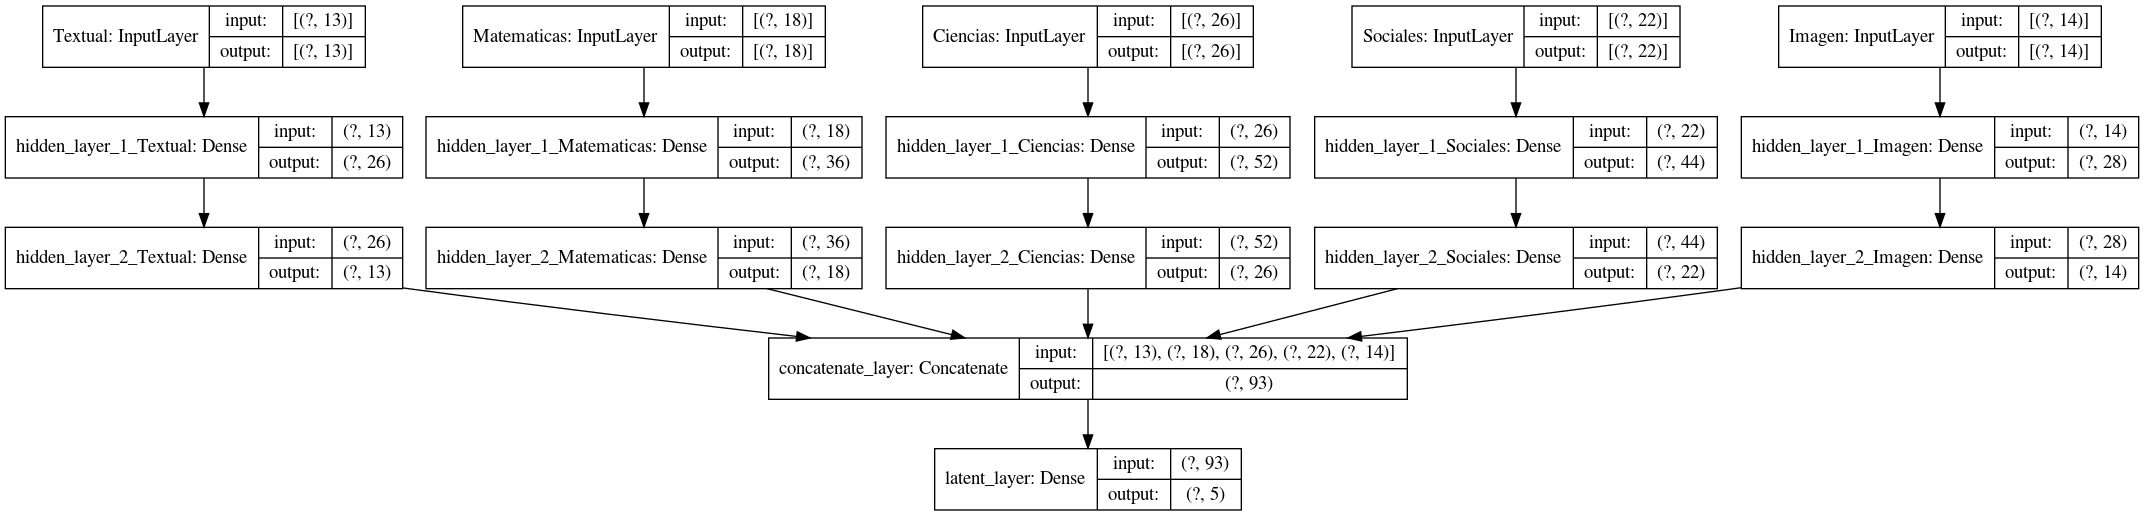

In [10]:
encoder_multi_uni.summary()
plot_model(encoder_multi_uni, to_file='../Imagenes/encoder_multi_uni.png',show_shapes=True)

### Decoder

In [11]:
# decoder
#
inputs_dec = Input(shape = (dim_latent,))
outputs_dec = Dense(datos.shape[1], name='generate_prob_data',activation='sigmoid',
               kernel_constraint=non_neg(), kernel_regularizer=regularizers.l2(1e-6))(inputs_dec)
#
decoder_multi_uni = Model(inputs=inputs_dec,outputs= outputs_dec, name='decoder_multi_uni')
#

### Summary

Model: "decoder_multi_uni"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
generate_prob_data (Dense)   (None, 93)                558       
Total params: 558
Trainable params: 558
Non-trainable params: 0
_________________________________________________________________


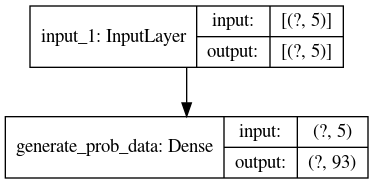

In [12]:
decoder_multi_uni.summary()
plot_model(decoder_multi_uni, to_file='decoder_multi_uni.png',show_shapes=True)

### Autoencoder

In [13]:
# Instantiate autoencoder model
autoencoder_multi_uni = Model(inputs= inputs, outputs=decoder_multi_uni(encoder_multi_uni(inputs)),
                   name='autoencoder_multi_uni')

#### Summary

Model: "autoencoder_multi_uni"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Textual (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
Matematicas (InputLayer)        [(None, 18)]         0                                            
__________________________________________________________________________________________________
Ciencias (InputLayer)           [(None, 26)]         0                                            
__________________________________________________________________________________________________
Sociales (InputLayer)           [(None, 22)]         0                                            
______________________________________________________________________________

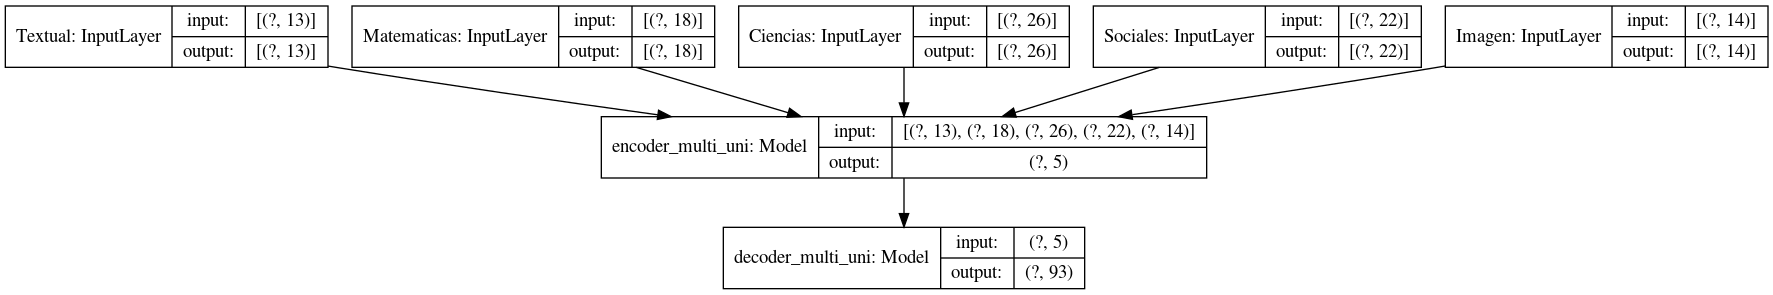

In [14]:
autoencoder_multi_uni.summary()
plot_model(autoencoder_multi_uni, to_file='../Imagenes/autoencoder_multi_uni.png',show_shapes=True)

## Compila 

Aquí se introduce el modelo irt 2pl. 

In [15]:
autoencoder_multi_uni.compile(loss= binary_crossentropy,
                  optimizer= Adam(),
                   metrics=['accuracy'])



## Entrena

In [16]:
epochs = 10
batch_size  = 32
#tf.random.set_seed(220)
#
history = autoencoder_multi_uni.fit(x_train,x_target, epochs= epochs,validation_split=0.2,
                             batch_size=batch_size)



Train on 25604 samples, validate on 6401 samples
Epoch 1/10
25604/25604 [==============================] - 10s 387us/sample - loss: 0.6024 - accuracy: 0.6875 - val_loss: 0.5778 - val_accuracy: 0.7027
Epoch 2/10
25604/25604 [==============================] - 6s 226us/sample - loss: 0.5735 - accuracy: 0.7043 - val_loss: 0.5684 - val_accuracy: 0.7074
Epoch 3/10
25604/25604 [==============================] - 5s 203us/sample - loss: 0.5670 - accuracy: 0.7084 - val_loss: 0.5640 - val_accuracy: 0.7104
Epoch 4/10
25604/25604 [==============================] - 6s 230us/sample - loss: 0.5637 - accuracy: 0.7107 - val_loss: 0.5617 - val_accuracy: 0.7118
Epoch 5/10
25604/25604 [==============================] - 6s 235us/sample - loss: 0.5619 - accuracy: 0.7118 - val_loss: 0.5603 - val_accuracy: 0.7124
Epoch 6/10
25604/25604 [==============================] - 5s 212us/sample - loss: 0.5608 - accuracy: 0.7122 - val_loss: 0.5594 - val_accuracy: 0.7130
Epoch 7/10
25604/25604 [==========================

## Recupera parámetros de los ítems

In [22]:
item_params  = decoder_multi_uni.get_weights()
item_params = np.vstack([np.array(item_params[0]),np.array(item_params[1])])
item_params = pd.DataFrame(np .transpose(item_params))

#colnames = areas_name + ['intercepto'] 
colnames =['dim_1', 'dim_2','dim_3','dim_4','dim_5','intercepto']
item_params.columns =colnames


In [24]:
item_params.tail(20)

,dim_1,dim_2,dim_3,dim_4,dim_5,intercepto
73,0.783250,0.014936,0.056178,0.417036,0.000342,0.174604
74,0.440168,0.338847,0.381606,0.312618,0.728497,-0.151019
75,0.588449,0.513363,0.769051,0.072598,0.241074,-0.470290
76,1.021281,0.008987,0.114650,0.398938,-0.000000,0.317895
77,0.199119,0.373349,0.549417,0.112643,0.233194,-0.346634
78,0.181603,0.570739,0.689867,0.171710,0.550637,-0.553653
79,0.245582,0.206698,0.236181,0.932611,0.973906,-0.039936
80,0.379502,0.003327,0.163707,1.520140,0.867477,0.205521
81,-0.000000,0.648921,0.407299,0.085042,0.777878,-0.569017
82,0.482570,0.002837,0.026462,1.577592,0.305957,0.728833


In [25]:
autoencoder_multi_uni.evaluate(x_test,x_target_test )

3557/3557 [==============================] - 1s 211us/sample - loss: 0.5514 - accuracy: 0.7172


[0.551389259503804, 0.71719265]

OK:
[loss, accuracy] = [0.551389259503804, 0.71719265]

## Gráficos 

In [19]:
latent_test= encoder_multi_uni.predict(x_test)

In [20]:
latent_test.shape

(3557, 5)

In [116]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [140]:
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(latent_test)
labels = x_test.index


In [ ]:
#labels = None
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [21]:
data_plot = latent_test
ax = plt.figure(figsize=(20,16)).gca(projection='3d')
ax.scatter(
    xs=data_plot[:,0],
    ys=data_plot[:,1], 
    zs=data_plot[:,2],
    cmap='tab10',
    )
ax.set_xlabel('Textual')
ax.set_ylabel('Matemática')
ax.set_zlabel('Ciencias')

#ax.set_xlim([0,4])
#ax.set_ylim([-5,0])
#ax.set_zlim([0,4])
plt.show()

NameError: name 'plt' is not defined